# Predicting attrition with classification models

## Import all packages needed.

In [1]:
! pip install xgboost

C:\Users\PQRT\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


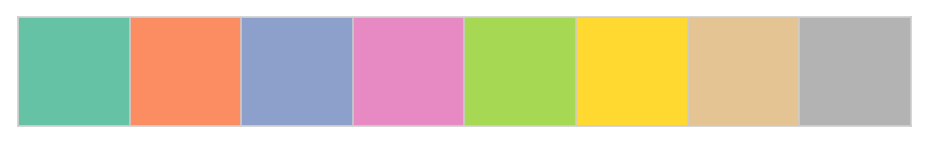

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

import os
import itertools

sns.set_style('whitegrid')
sns.set_palette("Set2")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.palplot(sns.color_palette())

## 1. Data Cleaning & Preparation

In [3]:
""" Load in the data and examine the head. """

data = 'input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv'
df = pd.read_csv(data)
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Target column - Attrition
    -Binary target currently Yes/no

### Examine columns

In [4]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

### Check dataset shape

In [5]:
df.shape

(1470, 35)

### view dataframe info
    - check for missing values
    - examine the different datatypes

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

### Use the describe function to examine the dataframe further
    - Look for outstanding numbers or consistency
    - This will only show the numeric columns (may need to examine categorical variables further individually)

In [7]:
""" Transpose the describe to make it easier to read. """
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


#### insights gained from this:
- columns such as education that are numerical that actually represent categorical variables may need further investigation.
- EmployeeCount is a constant column with all values being 1.
- performance rating whilst being on a scale of 1-4, only has 3s and 4s.
- Standard Hours is a constant column with all values being 80 hours.

## Do any Cleaning needed


In [8]:
""" Drop the two constant columns. """

df.drop(['EmployeeCount','EmployeeNumber'],axis=1,inplace=True)

In [9]:
""" Investigate categorical columns that seem irrelevent. """

df.Over18.value_counts()

Y    1470
Name: Over18, dtype: int64

In [10]:
""" Drop Over18 as it is also a constant. """

df.drop('Over18',axis=1,inplace=True)

In [11]:
""" Alter the Education column to show categorical variables. This will later be dummied for modelling. """

df.replace({'Education':{1:'Below_college', 2:'College', 3:'Bachelor', 4:'Masters', 5:'Doctor'}}, inplace=True)

In [12]:
""" Iterate through the dataframes columns and covert to lowercase. """
low_col = []
for i in df.columns:
    i = i.lower()
    low_col.append(i)
df.columns = low_col

In [13]:
df.columns

Index(['age', 'attrition', 'businesstravel', 'dailyrate', 'department',
       'distancefromhome', 'education', 'educationfield',
       'environmentsatisfaction', 'gender', 'hourlyrate', 'jobinvolvement',
       'joblevel', 'jobrole', 'jobsatisfaction', 'maritalstatus',
       'monthlyincome', 'monthlyrate', 'numcompaniesworked', 'overtime',
       'percentsalaryhike', 'performancerating', 'relationshipsatisfaction',
       'standardhours', 'stockoptionlevel', 'totalworkingyears',
       'trainingtimeslastyear', 'worklifebalance', 'yearsatcompany',
       'yearsincurrentrole', 'yearssincelastpromotion',
       'yearswithcurrmanager'],
      dtype='object')

In [14]:
# """ Save this dataframe in its current state before dummying for EDA purposes. """

df.to_csv('./Dataset/Clean_nodummy.csv')

In [15]:
""" Apply Pandas get_dummies function to the dataframe to transform the categorical variables to numeric.
    This will create additional columns in your dataframe."""

df_dum = pd.get_dummies(df)

In [16]:
""" Take a look at the shape before and after dummying to see how many new columns have been created. """

print(df.shape)
print(df_dum.shape)

(1470, 32)
(1470, 58)


In [17]:
df_dum.columns

Index(['age', 'dailyrate', 'distancefromhome', 'environmentsatisfaction',
       'hourlyrate', 'jobinvolvement', 'joblevel', 'jobsatisfaction',
       'monthlyincome', 'monthlyrate', 'numcompaniesworked',
       'percentsalaryhike', 'performancerating', 'relationshipsatisfaction',
       'standardhours', 'stockoptionlevel', 'totalworkingyears',
       'trainingtimeslastyear', 'worklifebalance', 'yearsatcompany',
       'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager',
       'attrition_No', 'attrition_Yes', 'businesstravel_Non-Travel',
       'businesstravel_Travel_Frequently', 'businesstravel_Travel_Rarely',
       'department_Human Resources', 'department_Research & Development',
       'department_Sales', 'education_Bachelor', 'education_Below_college',
       'education_College', 'education_Doctor', 'education_Masters',
       'educationfield_Human Resources', 'educationfield_Life Sciences',
       'educationfield_Marketing', 'educationfield_Medical',
       

In [18]:
df_dum.drop(['gender_Female','overtime_No','attrition_No'],axis=1,inplace=True)

In [19]:
""" Due to the presence of capital letters in the variables, once again iterate through and convert all the lowercase """
low_col = []
for i in df_dum.columns:
    i = i.lower()
    low_col.append(i)
df_dum.columns = low_col

In [20]:
df_dum.columns

Index(['age', 'dailyrate', 'distancefromhome', 'environmentsatisfaction',
       'hourlyrate', 'jobinvolvement', 'joblevel', 'jobsatisfaction',
       'monthlyincome', 'monthlyrate', 'numcompaniesworked',
       'percentsalaryhike', 'performancerating', 'relationshipsatisfaction',
       'standardhours', 'stockoptionlevel', 'totalworkingyears',
       'trainingtimeslastyear', 'worklifebalance', 'yearsatcompany',
       'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager',
       'attrition_yes', 'businesstravel_non-travel',
       'businesstravel_travel_frequently', 'businesstravel_travel_rarely',
       'department_human resources', 'department_research & development',
       'department_sales', 'education_bachelor', 'education_below_college',
       'education_college', 'education_doctor', 'education_masters',
       'educationfield_human resources', 'educationfield_life sciences',
       'educationfield_marketing', 'educationfield_medical',
       'educationfield_

In [21]:
#""" Export this dummied dataframe to be used in the modelling phase of this project. """
df_dum.to_csv('./Dataset/IBM_dummied.csv')

# 2. EDA

In this stage of the project, the main objective is to look further into the dataset and try and find insights and potential trends relating to the target variable in order to have a better understanding when it comes to selecting features for the modelling stage of the project.

In [22]:
""" Read in the Undummied CSV. """

df = pd.read_csv('Dataset/Clean_nodummy.csv', index_col=0)

In [23]:
""" Lets have a look at the target variable in this case. """

df.attrition.head()

0    Yes
1     No
2    Yes
3     No
4     No
Name: attrition, dtype: object

In [24]:
""" At the moment, this column is categorical. For use in visualisations etc. this will need to be numeric,
    so lets convert Yes and No, into binary, or 1's and 0's"""

df.loc[df.attrition == 'Yes', 'attrition'] = 1
df.loc[df.attrition == 'No', 'attrition'] = 0

In [25]:
""" Next, take a look at the value_counts to see the state of the target. """
df.attrition.value_counts()

0    1233
1     237
Name: attrition, dtype: int64

The first thing we can gather from this is that there is some definite class imbalance to this target variable, With non-attrition outweighing attrition heavily. 

This tells us that there may potentially be a need for over/under sampling.

It also means that the baselines for our models will be quite high to begin with as with a binary classification problem, the baseline is determined by the percentage of the dominating class.

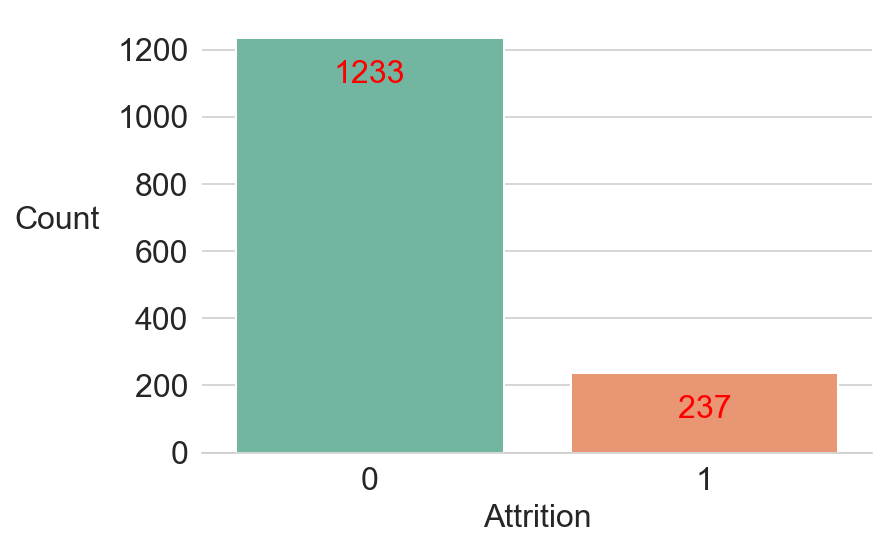

In [26]:
""" Lets plot the target variable to make it easier to visualise. """

""" Set the figure size. """
plt.figure(figsize=(6,4))

""" We will use a countplot here from the seaborn library. """
fig = sns.countplot(df.attrition)

""" sns.despine allows the customisation of the borders in the plot just for aesthetic purposes. """
sns.despine(left=True)

""" Configure the axes labels. """
fig.set_xlabel('Attrition', fontsize=16)
plt.xticks(fontsize=16)
fig.set_ylabel('Count', fontsize=16, rotation=0)
fig.yaxis.labelpad = 30
plt.yticks(fontsize=16)

""" Add annotations on the plot to show the actual count values on each of the columns."""
for p in fig.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    fig.annotate('{:}'.format(p.get_height()), (x.mean(), y-150), ha='center', va='bottom', fontsize=16, color='red')
plt.show()

In [27]:
""" Show the percentage breakdown of the target column. This also shows us the Baseline accuracy for our models. (83.9%) """

print('Percentage breakdown of Attrition')
print('-'*33)
round(df.attrition.value_counts(normalize=True)*100,2)

Percentage breakdown of Attrition
---------------------------------


0    83.88
1    16.12
Name: attrition, dtype: float64

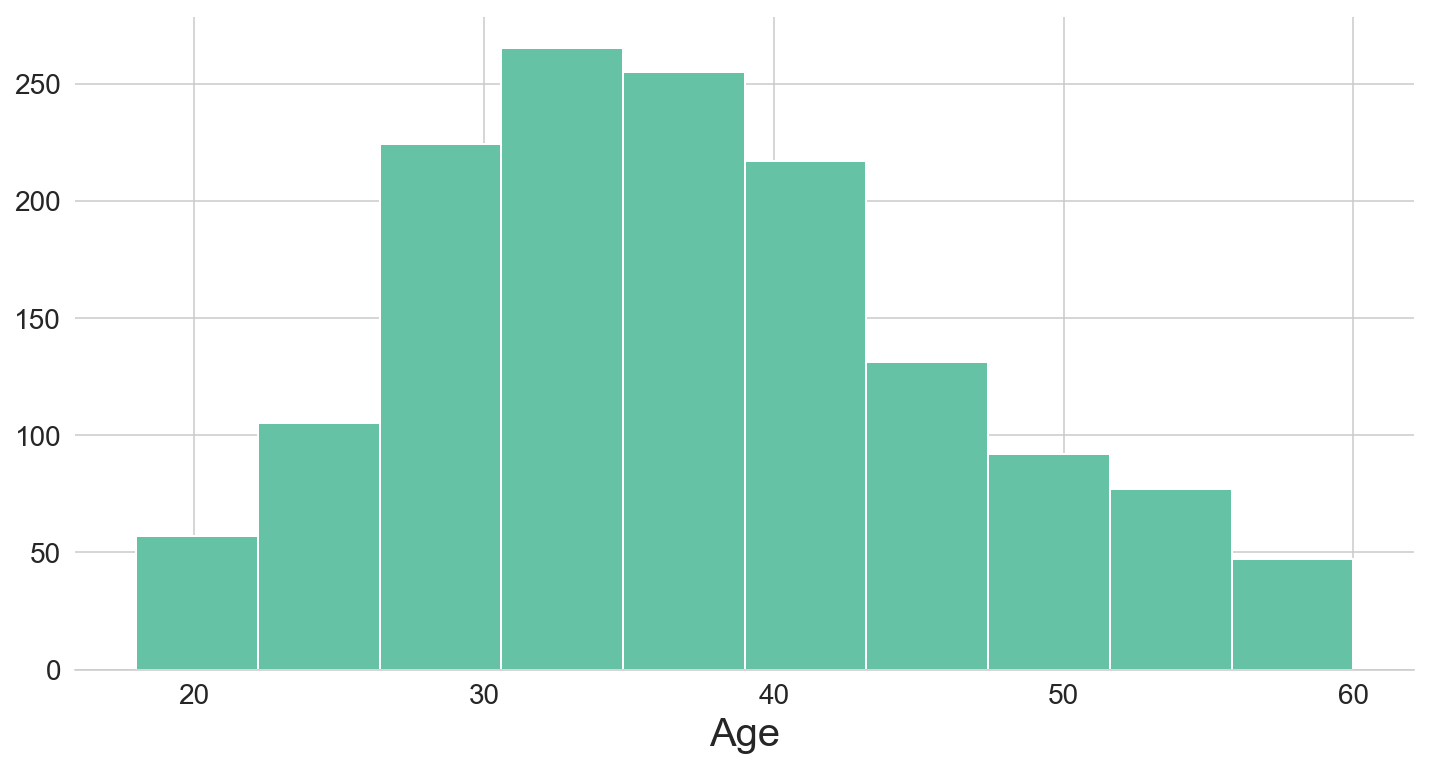

In [28]:
""" Plot the distribution of Age. """

plt.figure(figsize=(12,6))
fig = sns.distplot(df.age,kde=False, bins=10, hist_kws=dict(alpha=1))
sns.despine(left=True)
fig.set_xlabel('Age',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.yaxis.labelpad = 35
plt.show()

This graph shows a normal distribution with a slightly positive skew as indicated by the longer tail going off toward the right hand side.

Lets look into the Age feature in more detail in relation to the target variable.

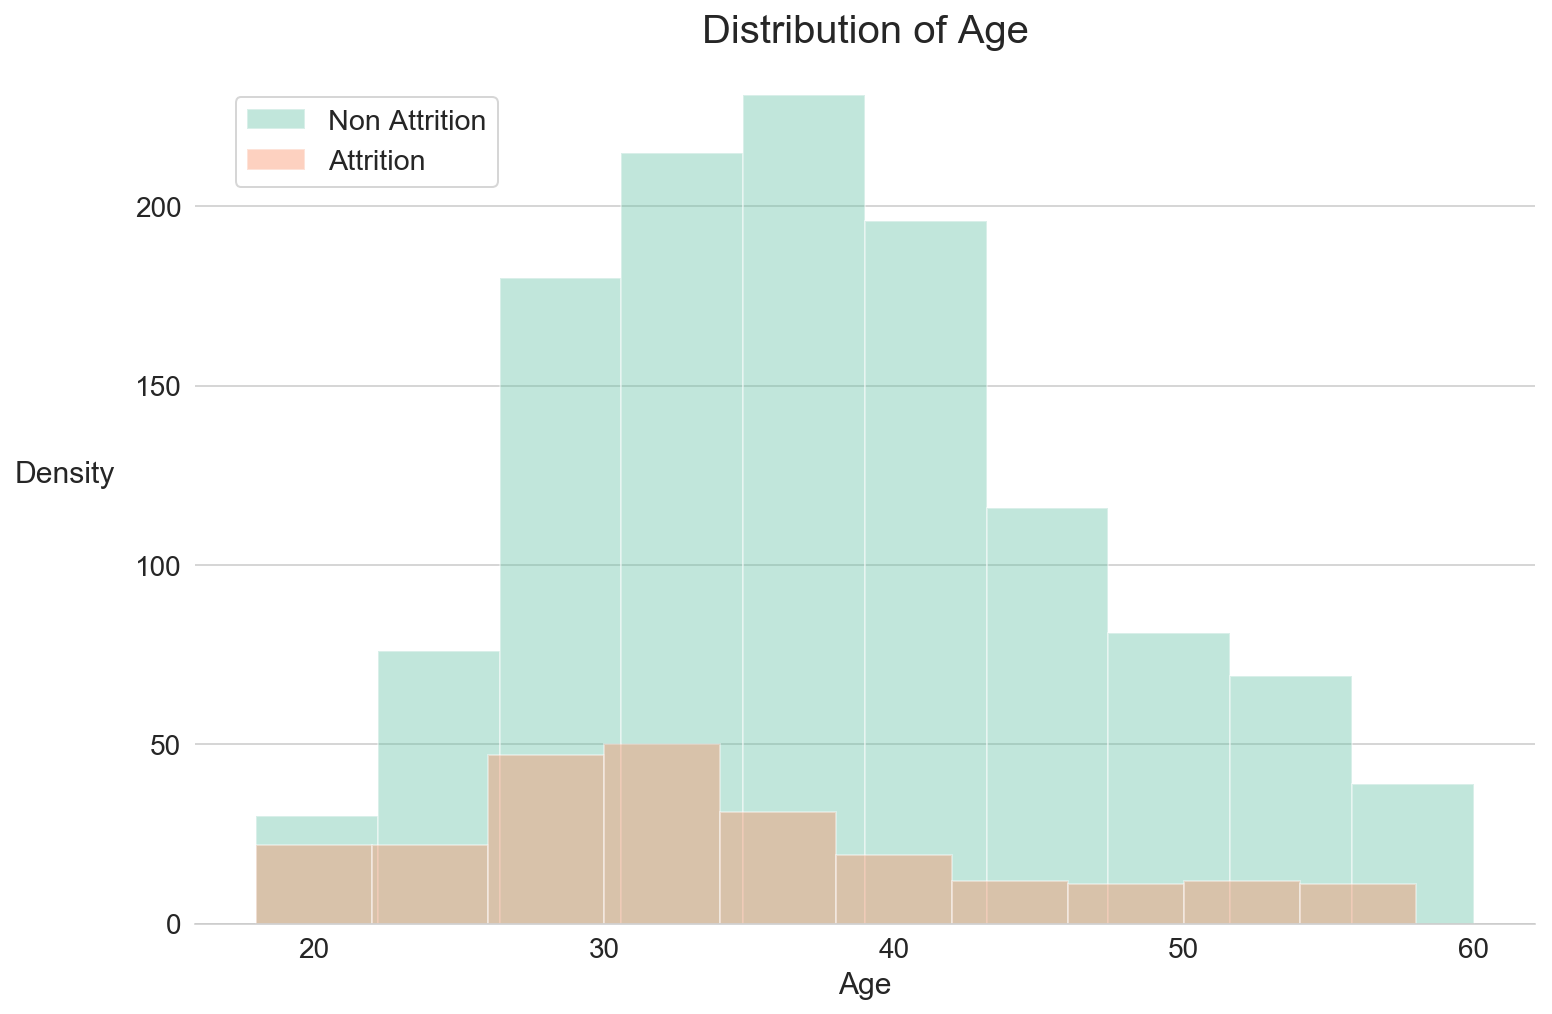

In [29]:
""" Plot the distribution of Age where attrition is true and false. """

plt.figure(figsize=(12,8))

""" Adjusting the bin size can alter the look of your graph, worth testing different sizes to see various plots. """
fig = sns.distplot(df[df['attrition'] == 0]['age'], label='Non Attrition', kde=0, bins=10)
sns.distplot(df[df['attrition'] == 1]['age'], label='Attrition', kde=0, bins=10)

sns.despine(left=1)

""" Removes the vertical gridlines. """
fig.grid(axis='x')

plt.xlabel('Age',fontsize=15)
plt.ylabel('Density',fontsize=15, rotation=0)
fig.yaxis.labelpad = 30
plt.title('Distribution of Age',fontsize=20);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.yaxis.labelpad = 35

""" Control the size and positioning of the legend. """
plt.legend(fontsize='x-large', bbox_to_anchor=(0.03, 0.95), loc=2, borderaxespad=0., frameon=1)
plt.show()

From this graph, we can see that attrition is present across all the age ranges.

However, for some age groups, attrition is much more prevalent. This is especially true in the early 20s age group where it is almost equal.

Attrition seems to be at its lowest in the mid 40s, and steadily increases as it gets closer the retirement age.

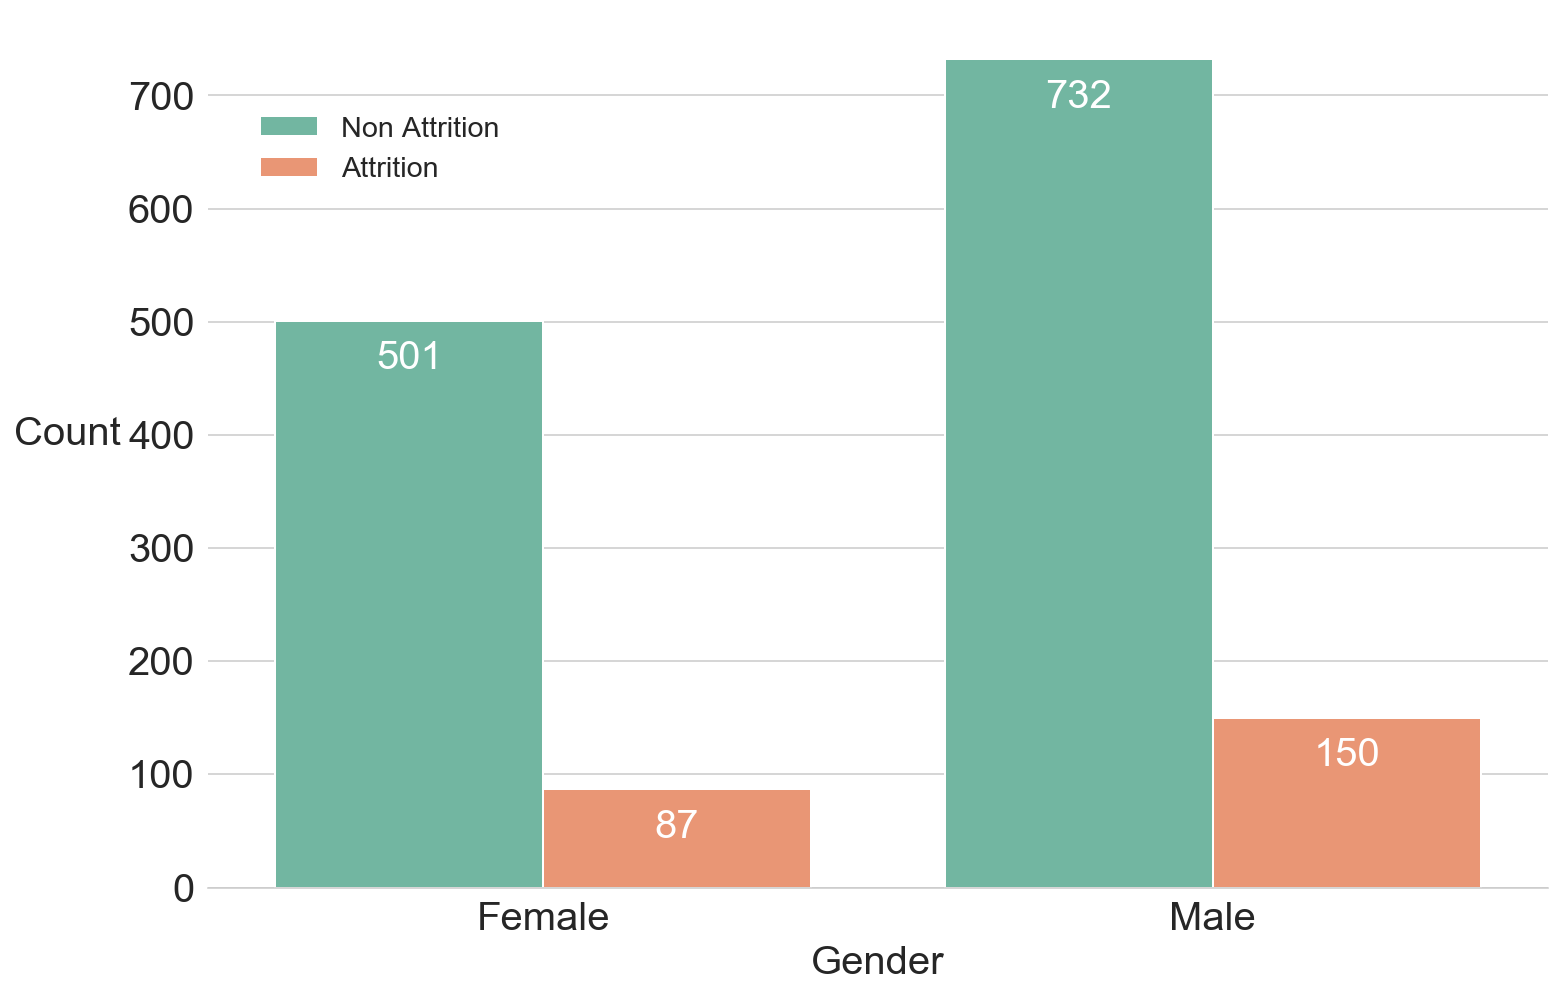

Female Attrition percentage & count
-----------------------------------
0    85.2
1    14.8
Name: attrition, dtype: float64
0    501
1     87
Name: attrition, dtype: int64
___________________________________

Male Attrition percentage & count
-----------------------------------
0    82.99
1    17.01
Name: attrition, dtype: float64
0    732
1    150
Name: attrition, dtype: int64
___________________________________


In [30]:
plt.figure(figsize=(12,8))
fig = sns.countplot(x='gender', hue='attrition', data=df)
sns.despine(left=True)
fig.set_xlabel('Gender', fontsize=20)
plt.xticks(fontsize=20)
fig.set_ylabel('Count', fontsize=20, rotation=0)
fig.yaxis.labelpad = 30
plt.yticks(fontsize=20)
for p in fig.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    fig.annotate('{:}'.format(p.get_height()), (x.mean(), y-50), ha='center', va='bottom', fontsize=20, color='white')
plt.legend(labels =['Non Attrition','Attrition'],fontsize='x-large', bbox_to_anchor=(0.03, 0.9), loc=2, borderaxespad=0., frameon=0)
plt.show()

print('Female Attrition percentage & count')
print('-'*35)
print(round(df[df.gender == 'Female'].attrition.value_counts(normalize=True)*100,2))
print(df[df.gender == 'Female'].attrition.value_counts())
print('_'*35)
print(''*35)
print('Male Attrition percentage & count')
print('-'*35)
print(round(df[df.gender == 'Male'].attrition.value_counts(normalize=True)*100,2))
print(df[df.gender == 'Male'].attrition.value_counts())
print('_'*35)

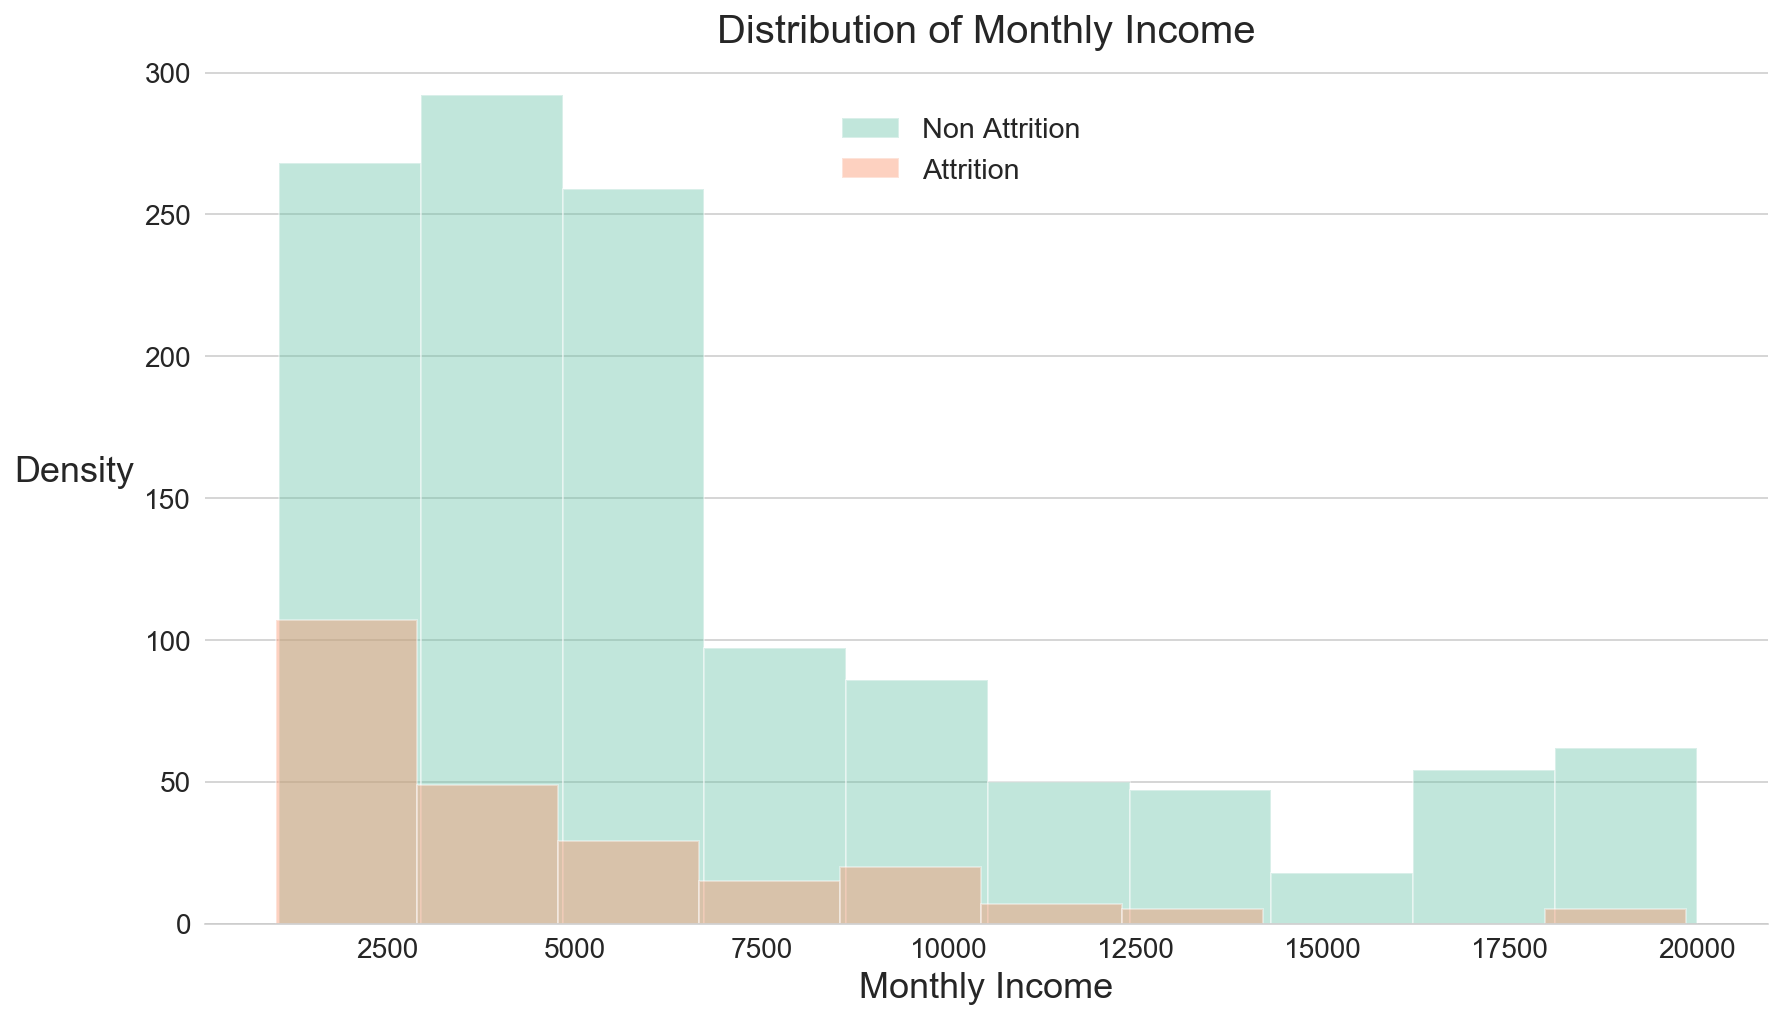

Average Monthly Income: 6502.931292517007
Average Monthly Income for Males: 6380.507936507936
Average Monthly Income for Females: 6686.566326530612


In [31]:
plt.figure(figsize=(14,8))
fig = sns.distplot(df[df['attrition'] == 0]['monthlyincome'], label='Non Attrition', kde=0, bins=10)
sns.distplot(df[df['attrition'] == 1]['monthlyincome'], label='Attrition', kde=0, bins=10)
sns.despine(left=1)
fig.grid(axis='x')
plt.xlabel('Monthly Income',fontsize=18)
plt.ylabel('Density',fontsize=18, rotation=0)
fig.yaxis.labelpad = 30
plt.title('Distribution of Monthly Income',fontsize=20);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.yaxis.labelpad = 35
plt.legend(fontsize='x-large', bbox_to_anchor=(0.4, 0.94), loc=2, borderaxespad=0., frameon=0)
plt.show()
print('Average Monthly Income:',df.monthlyincome.mean())
print('Average Monthly Income for Males:',df[df.gender == 'Male']['monthlyincome'].mean())
print('Average Monthly Income for Females:',df[df.gender == 'Female']['monthlyincome'].mean())

In [33]:
income = df.groupby(by='jobrole').mean().monthlyincome
inc = pd.DataFrame(income)
inc = inc.sort_values(by='monthlyincome')

In [34]:
job_atr = df[df['attrition'] == 1]['jobrole']
job_atr_val = job_atr.value_counts()
job_atr_df = pd.DataFrame(job_atr_val)

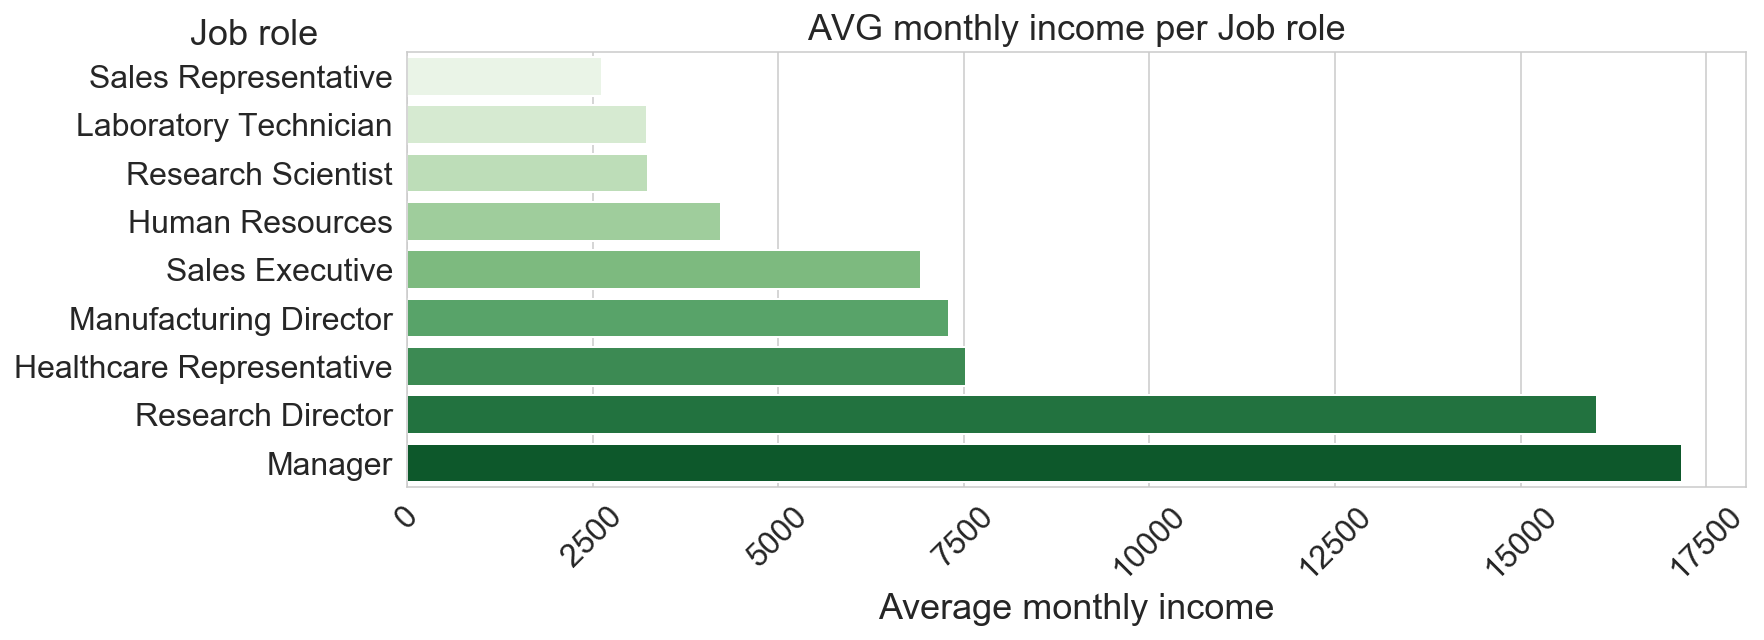

In [35]:
plt.figure(figsize=(12,4))
fig = sns.barplot(y=inc.index, x='monthlyincome', data=inc,
                  palette=sns.color_palette("Greens", n_colors=len(inc.index)))
fig.set_title('AVG monthly income per Job role',fontsize=18)
fig.set_xlabel('Average monthly income', fontsize=18)
fig.set_ylabel('Job role', fontsize=18, position=(0,1), rotation=0)
fig.yaxis.labelpad= -120
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.show()


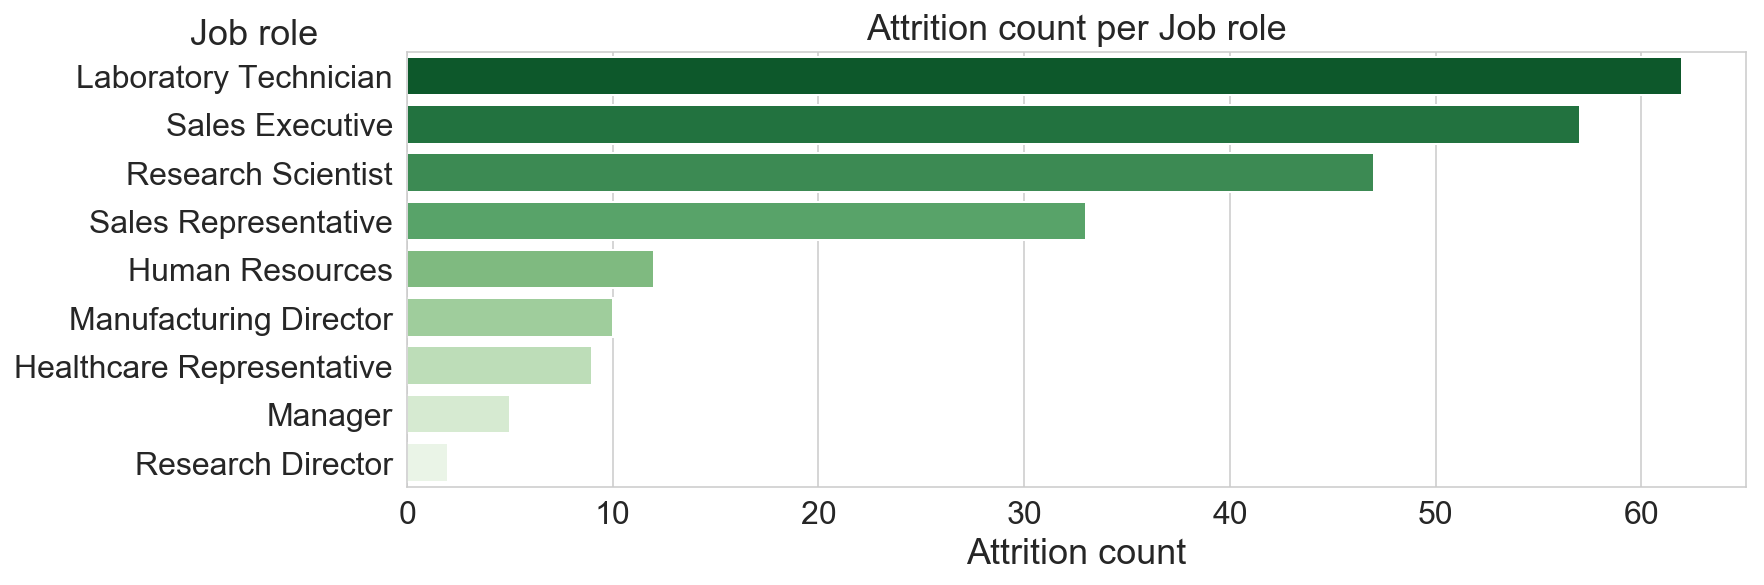

In [36]:
plt.figure(figsize=(12,4))
fig = sns.barplot(y=job_atr_df.index, x='jobrole', data=job_atr_df, 
                  palette=sns.color_palette("Greens_r", n_colors=len(job_atr_df.index)))
fig.set_title('Attrition count per Job role',fontsize=18)
fig.set_xlabel('Attrition count', fontsize=18)
fig.set_ylabel('Job role', fontsize=18, position=(0,1), rotation=0)
fig.yaxis.labelpad= -120
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.show()

Showing the average monthly income per job role on top of the attrition count per job role unveils an interesting relationship with the highest paid jobs averaging the lowest attrition and vice versa. Jobs such as Sales executive however go against this trend with a higher average income whilst recording the second highest attrition rate out of all the job roles.

In [37]:
edu_sal = df.groupby('education').mean().monthlyincome
edu_sal_df=pd.DataFrame(edu_sal)
edu_sal_df = edu_sal_df.sort_values('monthlyincome', ascending=False)

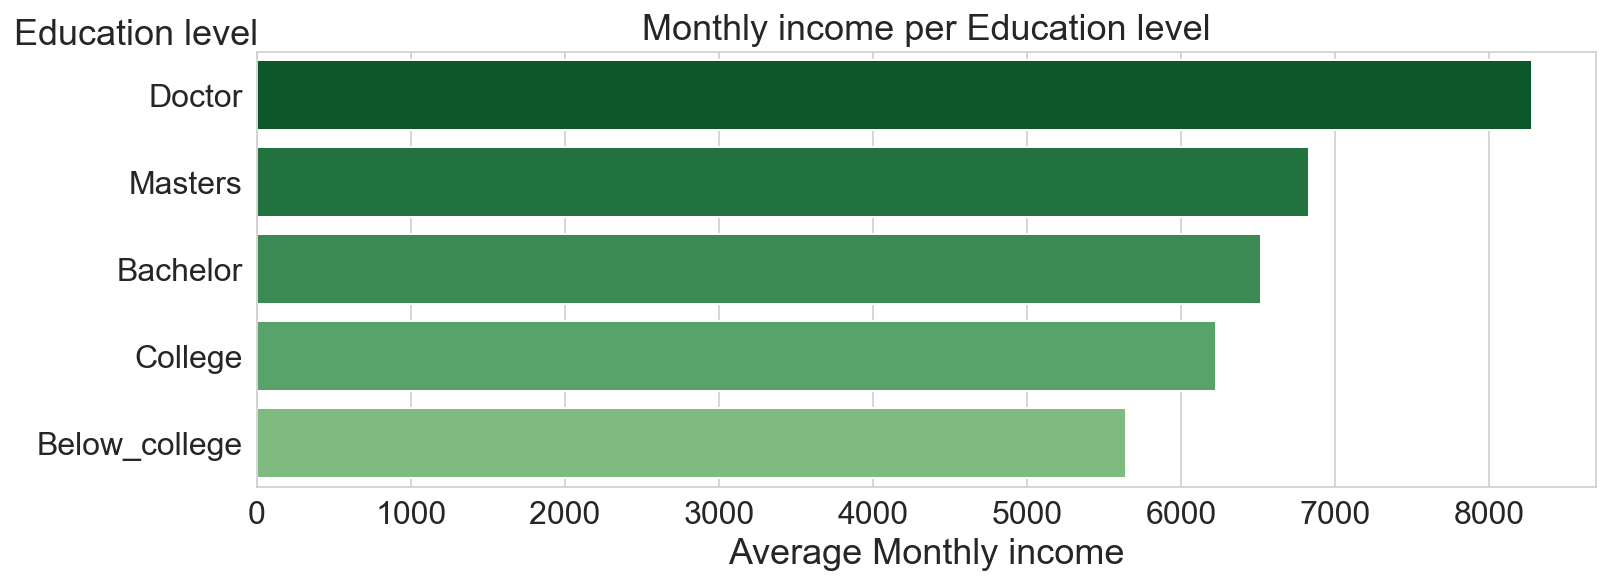

In [38]:
plt.figure(figsize=(12,4))
fig = sns.barplot(y=edu_sal_df.index, x='monthlyincome', data=edu_sal_df, 
                  palette=sns.color_palette("Greens_r", n_colors=len(job_atr_df.index)))
fig.set_title('Monthly income per Education level',fontsize=18)
fig.set_xlabel('Average Monthly income', fontsize=18)
fig.set_ylabel('Education level', fontsize=18, position=(0,1), rotation=0)
fig.yaxis.labelpad= -50
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.show()

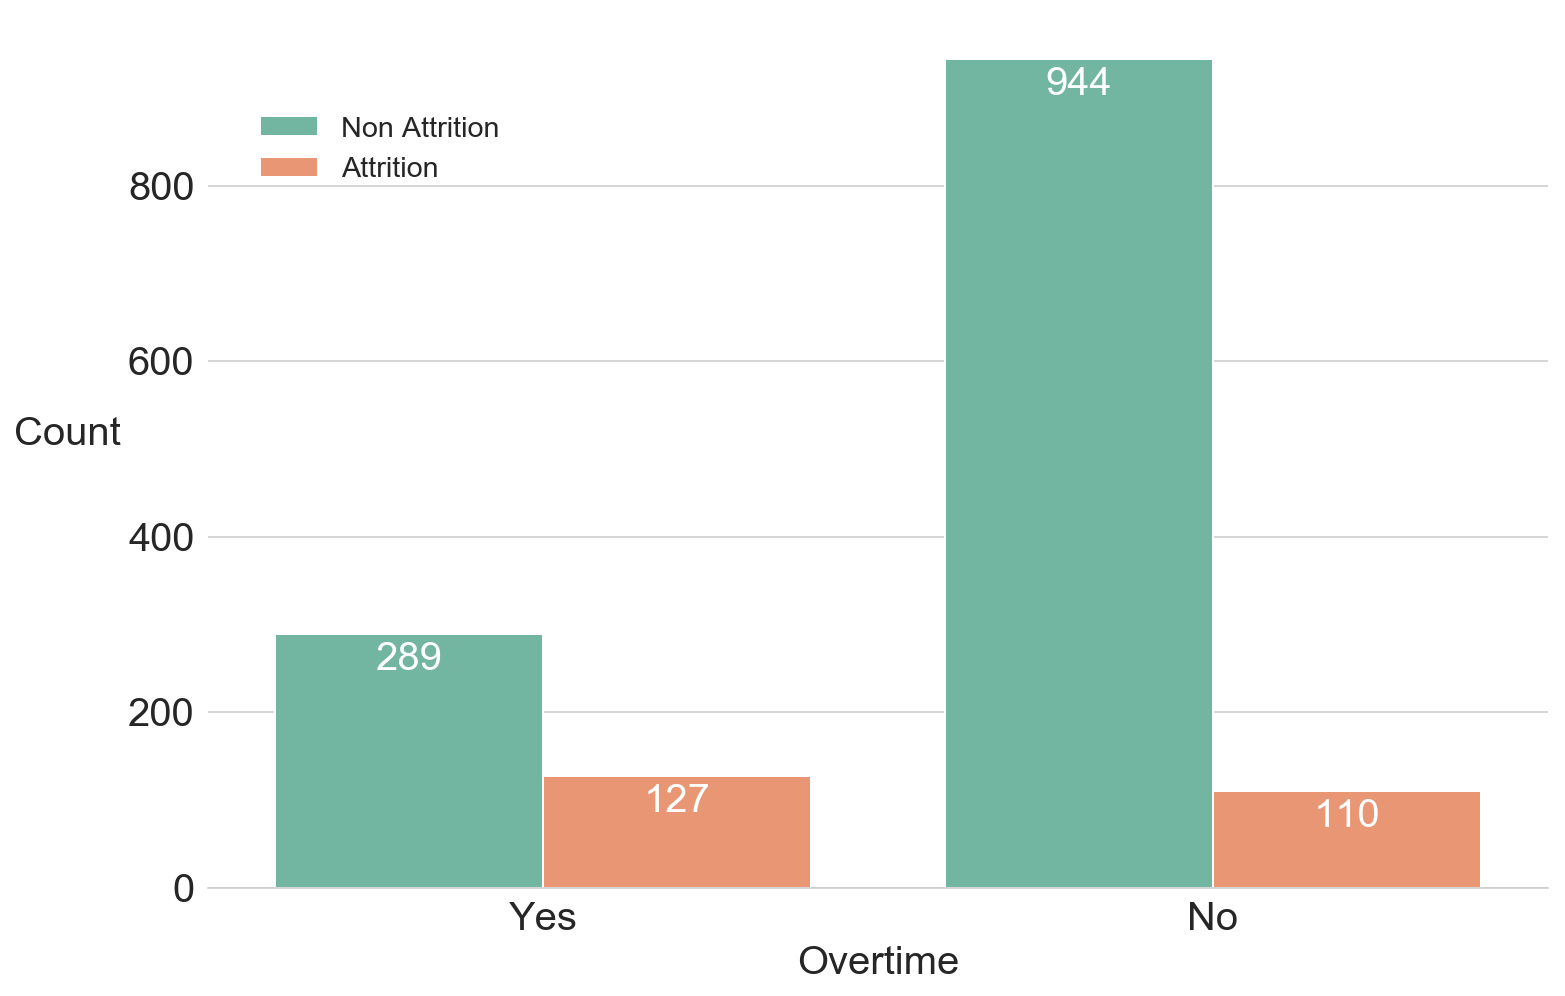

In [39]:
plt.figure(figsize=(12,8))
fig = sns.countplot(x='overtime', hue='attrition', data=df)
sns.despine(left=True)
fig.set_xlabel('Overtime', fontsize=20)
plt.xticks(fontsize=20)
fig.set_ylabel('Count', fontsize=20, rotation=0)
fig.yaxis.labelpad = 30
plt.yticks(fontsize=20)
for p in fig.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    fig.annotate('{:}'.format(p.get_height()), (x.mean(), y-50), ha='center', va='bottom', fontsize=20, color='white')
plt.legend(labels =['Non Attrition','Attrition'],fontsize='x-large', bbox_to_anchor=(0.03, 0.9), loc=2, borderaxespad=0., frameon=0)
plt.show()

### EDA Summary
From this brief EDA of the dataset there are numerous things that stand out in relation to attrition.
##### Class imbalance
Class imbalance in the target variable can be problematic when it comes to machine learning, and in relation to this dataset our focus is the minority class. Class imbalance creates a high baseline accuracy for our models to improve on. Methods to reduce this imbalance may be needed such as under/oversampling.
###### Attrition & Age
Attrition seems to be more prevalent in the early career stages, most notebly between the ages of 20 and 30. Whilst there is records of attrition at almost every age grouping, it would be beneficial to retain these younger employees and develop them within the business.
###### Attrition & monthly income
While it isn't groundbreaking that the employees getting paid more are less likely to quit their jobs, exploring this area did uncover certain job roles where despite their pay level, attrition was abnormally higher than other roles. This relationship between income and retention could also be worth exploring in relation to preventing attrition, by offering incentives in the form of pay increases, how much of an effect, if any, would this have on the employees attrition chance.
###### Attrition & overtime
Employees that worked overtime had a much higher rate of attrition than their colleagues that didnt have to. By increasing the total number of hours worked and making workers stay late/arrive early the chance of them leaving increases. Again this provides another potential area of focus to improve employee retention, by minimising overtime hours, employee satisfaction could increase and the chance of attrition could go down for this specific group of employees.

# 3. Implementing Machine Learning

In this stage of the project, the aim is to train a model on a subset of the data (training data) that successfully predicts our target variable of a different subset (test data) more accurately than baseline. By utilizing numerous models, it is possible to assess each model used and then fine tune the best performing to output the best possibly accuracy for this dataset.

As this is a relatively small dataset, i will be using a wide variety of classification models as the computation time will not be very large. however, this strategy would not suit bigger, more complex datasets as running through multiple models may take an excessive amount of time, and in the real world, cost a business unnecessarily.

In [41]:
""" Start by loading in the dummied dataset we created earlier for modelling. """
data = 'Dataset/IBM_dummied.csv'
df = pd.read_csv(data, index_col=0)

""" Convert all to float. """
df = df.astype(float)

df.shape

(1470, 55)

In [42]:
df.rename({'attrition_yes':'attrition'}, axis=1, inplace=True)

In [43]:
df.head()

,age,dailyrate,distancefromhome,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,...,jobrole_manager,jobrole_manufacturing director,jobrole_research director,jobrole_research scientist,jobrole_sales executive,jobrole_sales representative,maritalstatus_divorced,maritalstatus_married,maritalstatus_single,overtime_yes
0,41.0,1102.0,1.0,2.0,94.0,3.0,2.0,4.0,5993.0,19479.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,49.0,279.0,8.0,3.0,61.0,2.0,2.0,2.0,5130.0,24907.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,37.0,1373.0,2.0,4.0,92.0,2.0,1.0,3.0,2090.0,2396.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,33.0,1392.0,3.0,4.0,56.0,3.0,1.0,3.0,2909.0,23159.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,27.0,591.0,2.0,1.0,40.0,3.0,1.0,2.0,3468.0,16632.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [44]:
""" Seperate dataframe into the target and features. """
X = df.drop('attrition', axis=1)
y = df.attrition

In [45]:
""" Split the dataframe into the train and test groups. The split size can be specified, for this i am
    setting aside 20% for the testing data."""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1176, 54)
(294, 54)
(1176,)
(294,)


In [46]:
""" Find our baseline accuracy, using value_counts and taking the dominating class since this is a binary target.
    Our baseline accuracy is 83.9%"""
y.value_counts(normalize=True)

0.0    0.838776
1.0    0.161224
Name: attrition, dtype: float64

In [47]:
""" Defining the models i am going to use into a list. """
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()]
    
""" Logging for visual comparison. """ 

log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

""" Iterate through each classification model stated above, fitting the model to the train data and finally
    printing the accuracy and log loss of each model. """

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

LogisticRegression
****Results****
Accuracy: 88.0952%
Log Loss: 0.3034612340675392
KNeighborsClassifier
****Results****
Accuracy: 79.5918%
Log Loss: 2.716224716528208
SVC
****Results****
Accuracy: 85.3741%
Log Loss: 0.41741478186527825
DecisionTreeClassifier
****Results****
Accuracy: 78.9116%
Log Loss: 7.2836875390627975
RandomForestClassifier
****Results****
Accuracy: 85.3741%
Log Loss: 1.111589454444764
XGBClassifier
****Results****
Accuracy: 86.7347%
Log Loss: 0.39046556112322656
AdaBoostClassifier
****Results****
Accuracy: 87.4150%
Log Loss: 0.659287261593301
GradientBoostingClassifier
****Results****
Accuracy: 87.7551%
Log Loss: 0.31550523831928007
GaussianNB
****Results****
Accuracy: 76.1905%
Log Loss: 0.6086910973868418


In [48]:
""" From this, we can then sort by accuracy and log loss to effectively visualise our results. """

log1 = log.sort_values(by='Accuracy',ascending=False)
log2 = log.sort_values(by='Log Loss')

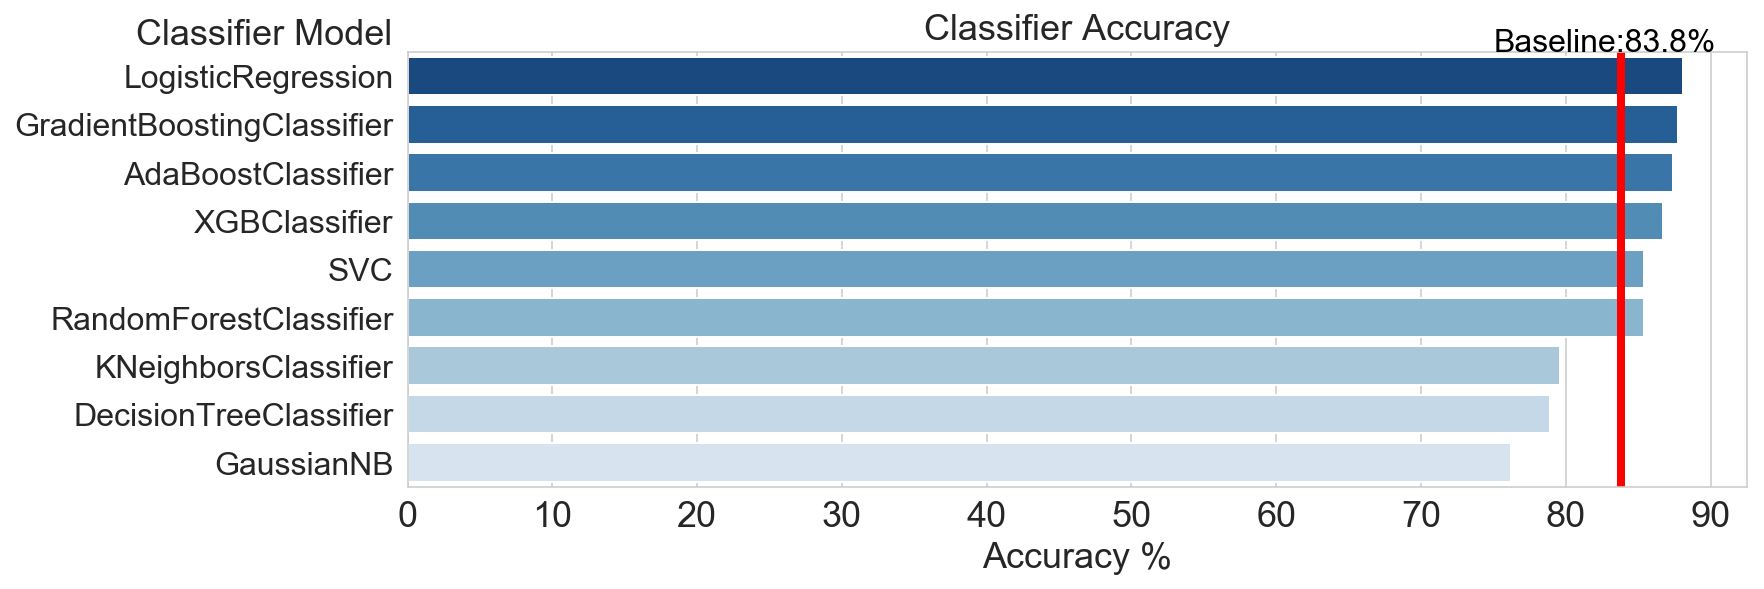

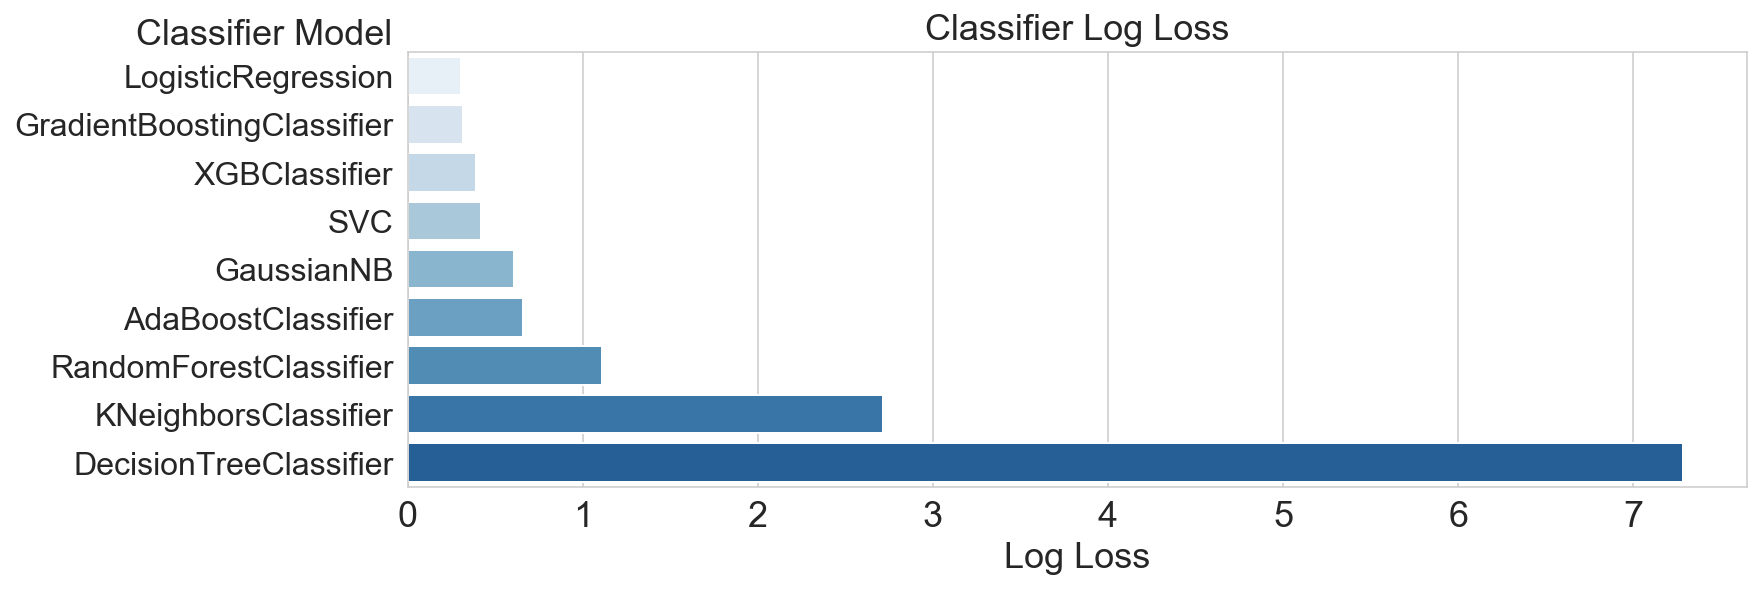

In [49]:
plt.figure(figsize=(12,4))
fig = sns.barplot(x='Accuracy', y='Classifier', data=log1, palette=sns.color_palette("Blues_r", n_colors=len('classifier')))
plt.xlabel('Accuracy %', fontsize=18)
plt.ylabel('Classifier Model',fontsize=18, position=(0,1),rotation=0)
fig.yaxis.labelpad= -125
fig.set_xticks(ticks=[0,10,20,30,40,50,60,70,80,90])
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.title('Classifier Accuracy', fontsize=18)
plt.axvline(83.8, 0,1, lw=4, color='red')
plt.annotate(s='Baseline:83.8%', xy=(75,-0.5), fontsize=16, color='black')
plt.show()

plt.figure(figsize=(12,4))
fig = sns.barplot(x='Log Loss', y='Classifier', data=log2, palette=sns.color_palette("Blues", n_colors=len('Classifier')))
plt.xlabel('Log Loss', fontsize=18)
plt.ylabel('Classifier Model',fontsize=18, position=(0,1),rotation=0)
fig.yaxis.labelpad= -125
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.title('Classifier Log Loss', fontsize=18)
plt.show()

### Initial results
After training all the different classification models and visualising their accuracy and log loss, multiple models managed to predict more accurately than baseline. However, from here we can now choose the best model from this and further tweak this model through model tuning to see if we can improve the score any more.

The logistic regression model stands out at the moment as our best model to improve on. This makes sense as it is the most common and often most accurate when presenting with a binary target.

# 4. Model tuning

Now that we have a model that sufficiently predicts above baseline, we can then apply further techniques to tune this model through various penalties and parameters. This can also include feature selection depending on the model. For this Logisitic Regression model, I will be using GridsearchCV to find the optimal C parameter and penalty to use to get the best accruacy for this dataset.

In [50]:
""" Create the parameter grid that will be supplied and applied to the model on each iteration. """

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty':['l1','l2'] }

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(LogisticRegression(), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l1', tol=0.0001),
             param_grid=param_grid)

GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
clf.fit(X_train, y_train)
clf.param_grid

{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [52]:
""" Create a new DataFrame containing the results from the gridsearch, with the C param and penalty associated. """

results = pd.DataFrame(clf.cv_results_)
final = results[['param_C','param_penalty','mean_test_score']].sort_values('mean_test_score')
final

,param_C,param_penalty,mean_test_score
0,0.001,l1,0.835034
1,0.001,l2,0.835034
2,0.01,l1,0.835034
3,0.01,l2,0.847789
4,0.1,l1,0.857143
12,1000,l1,0.869048
10,100,l1,0.869898
8,10,l1,0.870748
11,100,l2,0.870748
13,1000,l2,0.870748


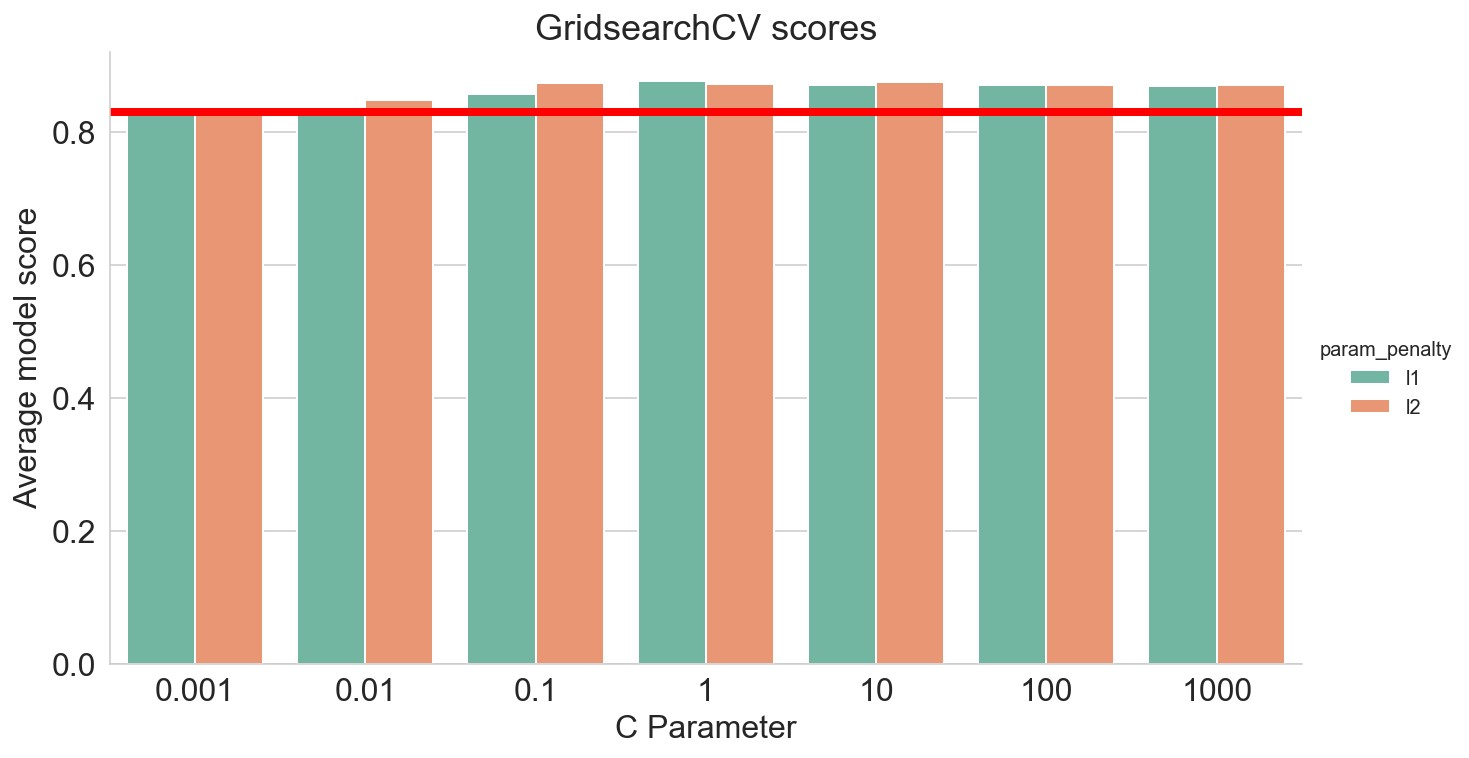

In [53]:
""" Using a catplot, show the average model score for each version of the model. """

sns.catplot(y='mean_test_score', x='param_C', hue='param_penalty', data=final, kind='bar', aspect=15/8.27)
plt.axhline(0.83, 0,1, lw=4, color='red')
plt.title('GridsearchCV scores',fontsize=18)
plt.xlabel('C Parameter', fontsize=16)
plt.ylabel('Average model score', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [54]:
""" Print out the best parameters for the model, along with the final score utilizing these parameters. """
print(clf.best_params_)
print("="*30)
print(clf.best_estimator_)
print("="*30)
print(clf.best_score_)
print("="*30)
y_predict = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_predict)
print('Accuracy of the best classifier after CV is %.2f%%' % (accuracy*100))

{'C': 1, 'penalty': 'l1'}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.8767006802721088
Accuracy of the best classifier after CV is 91.16%


# 5. Conclusion

##### final model
Through the use of many different classification models, and tuning the best performing, my final model was predicting with a 90.14% accuracy.

